# Automating the MUF
This notebook is an example of using the MUF as a scriptable service from python. Requires modifications to the MUF source code to replace the variable Application.StartupPath, as it will be registered as the path to python.exe instead of the MUF application. Written by Aric Sanders 10/2017.

This example requires the following dependencies:
1. The MUF
3. pythonnet
2. pyMeasure only for the bottom example.


## Automating a VNAUncert process

### Step 1. Importing packages and .net assemblies

In [1]:
# to use the python-.net bridge
import clr
# import sys for path
import sys
import os
# add the file paths to the .net assemblies (either dll or .exe)
# this is the location of my altered MUF version with the Application.StartupPath replaced 
# with a hard coded location
sys.path.append(r"C:\Share\MUF-develop\VNAUncertainty\bin\Debug")
sys.path.append(r"C:\Share\MUF-develop\PostProcessor\bin\Debug")
#For some reason it cannot find PNAGrabber, is there unmanaged c code? 
#sys.path.append(r"C:\Share\MUF-develop\PNAGrabber\bin\Debug")
#print(sys.path)
# create a reference to the applications that you want to use
clr.AddReference("Measurement")
clr.AddReference("PostProcessor")
clr.AddReference("VNAUncertainty")
#clr.AddReference("PNAGrabber")

# Now they can be imported as python libraries
import Measurement
import VNAUncertainty
import PostProcessor
#import PNAGrabber

### Step 2. Creating a class instance and initializing it

In [2]:
# now we can call the classes as python classes
# but we must trigger the OnLoad event to create the proper variables
# We must create a .net event first
from System import EventArgs
event=EventArgs()
# now if we want to run VNAUncertainty we create an instance and intialize it
vna=VNAUncertainty.VNAUncertainty()
vna.OnLoad(event)

### Step 3. Opening a menu 

In [3]:
# the basic command that loads a menu is .myOpenMenu
# We choose a menu that exits
vna.myOpenMenu(r"C:\Share\MUF_FILES\SOL_new.vnauncert_archive")

### Step 4. Running the calibration

In [4]:
# We then call RunCalibration in order to run VNAUncertainty
# This takes ~3seconds and will create a set of MUF files in a default location
vna.RunCalibration(0)

### Step 5. Closing the class instance

In [5]:
# we close the application after we are done
vna.Close()

# Repeating for an automated Measurement.exe

In [6]:
# If we wanted to do the same thing with Measurement.exe we would
# initialize the class and we can a plot remotely
measurement=Measurement.Measurement()
measurement.OnLoad(event)

In [7]:
# we open an existing .meas file
measurement.myOpenMenu(r"C:\8510calfiles\35CalComp\MUF_results\DUTs\M105P1.meas")
#measurement.Run()

In [8]:
# we can use the method .SavePlotToDisk to export data. 
# The integers are parameter,plot_type, curve_type
# parameter S11=0,..
# plot_type Linear Magnitude = 1
# curve_type Sensitvity Analysis Result = 0
# This function will not overwrite an existing file with the same name
measurement.SavePlotToDisk(os.path.join(os.getcwd(),"new_plot4.png"),0,1,1)
measurement.Close()

# Repeating for an automated PostProcessor.exe

In [20]:
# we can also run a post processor in the same way
post=PostProcessor.PostProcessor()
post.OnLoad(event)

In [21]:
post.myOpenMenu(r"C:\Share\MUF_FILES\Step 9 - Correct DUTs to 50 ohm\AtRefHalfThru_HF.post")

In [22]:
post.RunCalculation()

In [23]:
post.Close()

In [ ]:
pna=PNAGr

## Implementing a full solution using xml manipulation
From here down we use a package I have developed to make things easier currently called pyMeasure.

### Step 1. Importing my modules

In [9]:
# to load the pyMeasure API as configured
from pyMeasure import *
# this module is still experimental so it is not in the main import
from pyMeasure.Code.DataHandlers.MUFModels import *

Importing pyMeasure, this should take roughly 30 seconds


### Step 2. Using my XML menu handler to change values

In [25]:
#  now we can load the xml based vnauncert menu and manipulate it
vna_menu=MUFVNAUncert(r"C:\Share\MUF_FILES\SOL_new.vnauncert_archive")

In [26]:
# there are several helper functions for doing the most common things
vna_menu.get_results_directory()

'C:\\Data\\UncertDemo\\UncertaintyAnalysis_SOL_OnePort'

In [28]:
# to check the action of a set/get 
vna_menu.set_results_directory("C:\\Data")
print(vna_menu.get_results_directory())

C:\Data


In [29]:
# we can save the new menu in a different location using .save(new_path)
vna_menu.save("new_menu.vnauncert_archive")

### Step 3. Use my script to run the vnauncert menu

In [30]:
# if we wanted to run it we can use a script version of the above automation 
run_muf_script("new_menu.vnauncert_archive")

VNAUncertainty finished running  at 2017-10-03 23:25:41.034000
The script took 1 seconds to run


### Step 4. Change something and run again

In [31]:
# we can change the number of montecarlos, the results directory and run again
vna_menu.set_number_montecarlo(1000)
vna_menu.set_results_directory("C:\\Data\\UncertDemo")
vna_menu.save("new_menu.vnauncert_archive")
run_muf_script("new_menu.vnauncert_archive")

VNAUncertainty finished running  at 2017-10-03 23:28:58.016000
The script took 35 seconds to run


## Example of testing the effect of the number of Monte Carlo Trials in a Script

In [10]:
# If we wanted to automate a series to investigate the effect of different number of trials, 
# we can write a script that sets the number of trails, runs then repeats
# by putting this into a function it allows others to call it later
def monte_carlo_trials_test_script(menu_or_archive,top_level_results_folder,number_trials_list=[10,15,20,30,100,1000]):
    """Takes a vnauncert menu and steps through different numbers of montecarlo trials saving the result"""
    vna_menu=MUFVNAUncert(menu_or_archive)
    # create and initialize a VNAUncert instance
    from System import EventArgs
    event=EventArgs()
    vna=VNAUncertainty.VNAUncertainty()
    vna.OnLoad(event)
    [directory_name,menu_name]=os.path.split(menu_or_archive)
    prefix_name=menu_name.split(".")[0]
    extension=menu_name.split(".")[-1]
    # we generate sub folders to store the results
    folders=[]
    total_start=datetime.datetime.utcnow()
    for number in number_trials_list:
        try:
            print("Begining N = {0}".format(number))
            start=datetime.datetime.utcnow()
            folder_name=os.path.join(top_level_results_folder,"N_{}".format(number))
            os.mkdir(folder_name)
            vna_menu.set_number_montecarlo(number)
            vna_menu.set_results_directory(folder_name)
            # rename and save the new menu
            new_menu_name=os.path.join(folder_name,prefix_name+"_N_{0}".format(number)+"."+extension)
            vna_menu.save(new_menu_name)
            vna.myOpenMenu(new_menu_name)
            vna.RunCalibration(0)
            stop=datetime.datetime.utcnow()
            runtime=stop-start
            print("Finished running N = {0} it took {1} seconds".format(number,runtime.seconds))
            print(" The new menu is {0} and results are in {1}".format(new_menu_name,folder_name))
            print("*"*80)
        except:
            print("Trial N = {0} failed moving to next trial".format(number))
            pass
    total_stop=datetime.datetime.utcnow()
    total_runtime=total_stop-total_start
    print("Montecarlo trial Script is finished, total runtime is {0} seconds".format(total_runtime.seconds))
        
    
    

In [13]:
monte_carlo_trials_test_script(r"C:\Share\8510calfiles\35CalComp\35CalComp_setup_TC.vnauncert_archive",
                               r"C:\Share\MonteCarlo_Trial_20171109")

Begining N = 10
Finished running N = 10 it took 14 seconds
 The new menu is C:\Share\MonteCarlo_Trial_20171109\N_10\35CalComp_setup_TC_N_10.vnauncert_archive and results are in C:\Share\MonteCarlo_Trial_20171109\N_10
********************************************************************************
Begining N = 15
Finished running N = 15 it took 10 seconds
 The new menu is C:\Share\MonteCarlo_Trial_20171109\N_15\35CalComp_setup_TC_N_15.vnauncert_archive and results are in C:\Share\MonteCarlo_Trial_20171109\N_15
********************************************************************************
Begining N = 20
Finished running N = 20 it took 14 seconds
 The new menu is C:\Share\MonteCarlo_Trial_20171109\N_20\35CalComp_setup_TC_N_20.vnauncert_archive and results are in C:\Share\MonteCarlo_Trial_20171109\N_20
********************************************************************************
Begining N = 30
Finished running N = 30 it took 15 seconds
 The new menu is C:\Share\MonteCarlo_Trial_2017

### Functional Plot. 
This sometimes falls a little short so here is where an inline script is really useful.

In [14]:
def plot_montecarlo_trial_S11(top_level_results_folder,dut_name,number_trials_list=[10,15,20,30,100,1000]):
    "generates a comparison plot for the S11 magnitude  of a montecarlo trial"
    folder_name=os.path.join(top_level_results_folder,"N_{}".format(number_trials_list[0]))
    nominal_file_path=os.path.join(folder_name,"DUTs","{0}_Support".format(dut_name),"{0}_0.s2p".format(dut_name))
    covariance_directory=os.path.join(folder_name,"DUTs","{0}_Support".format(dut_name),"Covariance")
    sensitvity_reference=create_sensitivity_reference_curve(nominal_file_path=nominal_file_path,
                                                            sensitivity_directory=covariance_directory,
                                                           format="MA")
    montecarlo_list=[]
    for index,number in enumerate(number_trials_list):
        folder_name=os.path.join(top_level_results_folder,"N_{}".format(number))
        montecarlo_folder_name=os.path.join(folder_name,"DUTs","{0}_Support".format(dut_name),"MonteCarlo")
        montecarlo_list.append(create_monte_carlo_reference_curve(montecarlo_folder_name,format="MA"))
        
    plt.close()
    plt.rcParams.update({'font.size': 22,'figure.figsize':(12,6)})
    for index,montecarlo in enumerate(montecarlo_list):
        montecarlo_magS11=np.array(montecarlo["magS11"])
        sensitivity_magS11=np.array(sensitvity_reference["magS11"])
        uncert_sensitvity=np.array(sensitvity_reference["umagS11"])
        uncert_montecarlo=np.array(montecarlo["umagS11"])
        f=np.array(sensitvity_reference["Frequency"])
        plt.plot(f,sensitivity_magS11-montecarlo_magS11,'-',label="N = {0}".format(number_trials_list[index]),alpha=.3)
    plt.fill_between(f,-1*uncert_sensitvity,uncert_sensitvity,
                        color="blue",
                        alpha=.25,
                        edgecolor="black",label="Sensitivity Uncertainty")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim([-.004,.004])
    plt.xlabel("Frequency(GHz)")
    plt.title("{0} Nominal-Montecarlo |S11| ".format(dut_name))
    plt.savefig(os.path.join(top_level_results_folder,
                             "MonteCarlo_Trial_Size_Test.png"),bbox_inches='tight')
    plt.show()
    

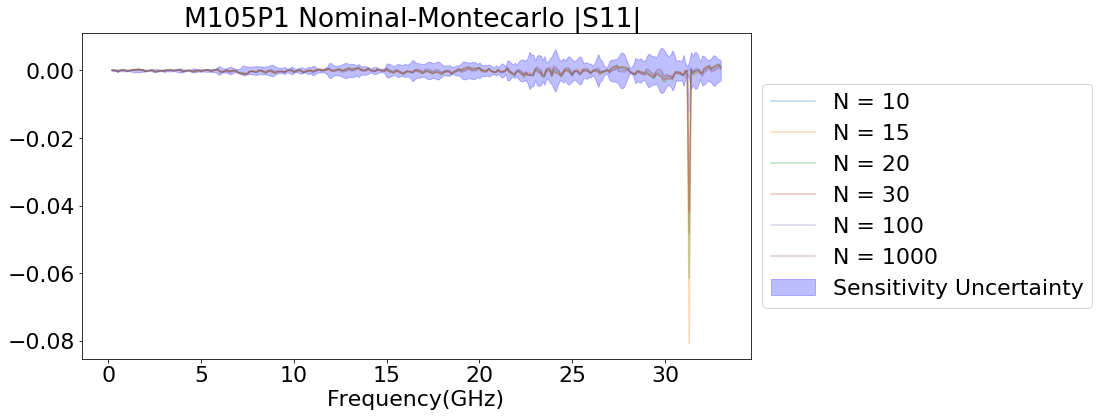

In [23]:
plot_montecarlo_trial_S11( r"C:\Share\MonteCarlo_Trial_20171109","M105P1")

### Inline script.
Notice in the above plot we can't really see the information of interest, we need to rescale the y-axis. There are a lot of options. We could use the `%matplotlib` magic to change the mode to notebook or wx. But I just copied and pasted the function above and made the cell into a script.

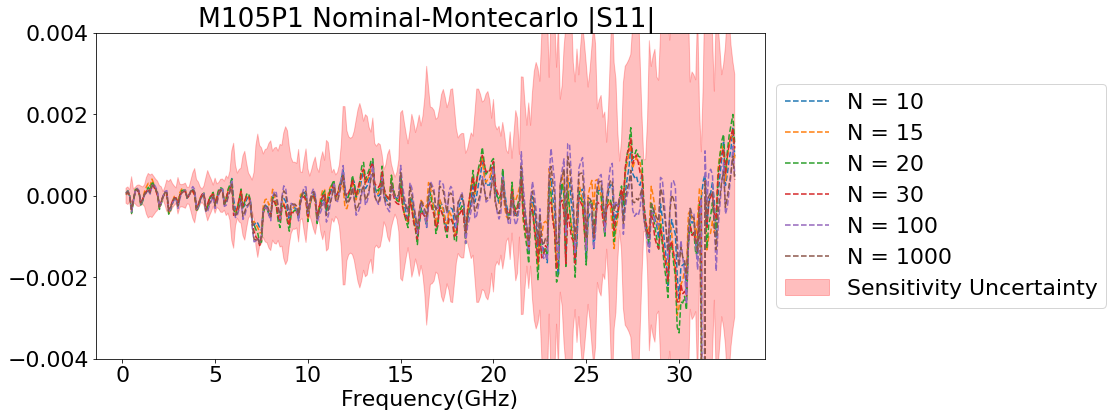

In [18]:
top_level_results_folder=r"C:\Share\MonteCarlo_Trial_20171109"
dut_name="M105P1"
number_trials_list=[10,15,20,30,100,1000]

folder_name=os.path.join(top_level_results_folder,"N_{}".format(number_trials_list[0]))
nominal_file_path=os.path.join(folder_name,"DUTs","{0}_Support".format(dut_name),"{0}_0.s2p".format(dut_name))
covariance_directory=os.path.join(folder_name,"DUTs","{0}_Support".format(dut_name),"Covariance")
sensitvity_reference=create_sensitivity_reference_curve(nominal_file_path=nominal_file_path,
                                                        sensitivity_directory=covariance_directory,
                                                       format="MA")
montecarlo_list=[]
for index,number in enumerate(number_trials_list):
    folder_name=os.path.join(top_level_results_folder,"N_{}".format(number))
    montecarlo_folder_name=os.path.join(folder_name,"DUTs","{0}_Support".format(dut_name),"MonteCarlo")
    montecarlo_list.append(create_monte_carlo_reference_curve(montecarlo_folder_name,format="MA"))

plt.close()
plt.rcParams.update({'font.size': 22,'figure.figsize':(12,6)})
for index,montecarlo in enumerate(montecarlo_list):
    montecarlo_magS11=np.array(montecarlo["magS11"])
    sensitivity_magS11=np.array(sensitvity_reference["magS11"])
    uncert_sensitvity=np.array(sensitvity_reference["umagS11"])
    uncert_montecarlo=np.array(montecarlo["umagS11"])
    f=np.array(sensitvity_reference["Frequency"])
    plt.plot(f,sensitivity_magS11-montecarlo_magS11,'--',label="N = {0}".format(number_trials_list[index]),alpha=1)
plt.fill_between(f,-1*uncert_sensitvity,uncert_sensitvity,
                    color="red",
                    alpha=.25,
                    edgecolor="black",label="Sensitivity Uncertainty")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-.004,.004])
plt.xlabel("Frequency(GHz)")
plt.title("{0} Nominal-Montecarlo |S11| ".format(dut_name))
plt.savefig(os.path.join(top_level_results_folder,
                         "MonteCarlo_Trial_Size_Test2.png"),bbox_inches='tight')
plt.show()

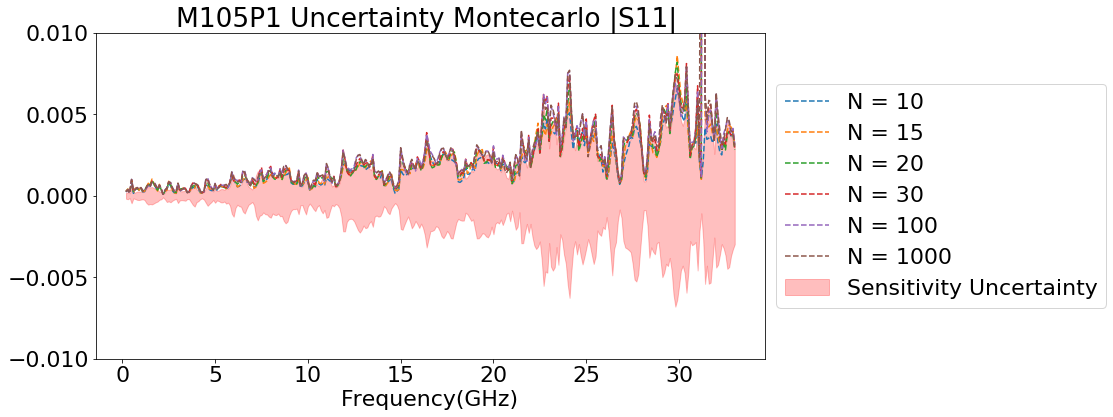

In [21]:
plt.close()
for index,montecarlo in enumerate(montecarlo_list):
    montecarlo_magS11=np.array(montecarlo["magS11"])
    sensitivity_magS11=np.array(sensitvity_reference["magS11"])
    uncert_sensitvity=np.array(sensitvity_reference["umagS11"])
    uncert_montecarlo=np.array(montecarlo["umagS11"])
    f=np.array(sensitvity_reference["Frequency"])
    plt.plot(f,uncert_montecarlo,'--',label="N = {0}".format(number_trials_list[index]),alpha=1)
plt.fill_between(f,-1*uncert_sensitvity,uncert_sensitvity,
                    color="red",
                    alpha=.25,
                    edgecolor="black",label="Sensitivity Uncertainty")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-.01,.01])
plt.xlabel("Frequency(GHz)")
plt.title("{0} Uncertainty Montecarlo |S11| ".format(dut_name))
plt.savefig(os.path.join(top_level_results_folder,
                         "MonteCarlo_Trial_Size_Test2.png"),bbox_inches='tight')
plt.show()

## Analysis 
The plot above shows that it is rare for the difference of the statistically biased mean and nominal value to exceed the uncertainty from the sensitivity analysis. Here the difference between 100 trials and 1000 is very little (except a factor of ten in time). In addition, we see a strange stability issue in the statistically biased mean, that exists for all number of Monte Carlo trials. Early tests indicate this is a stability issue in TRL for the distribution widths chosen for certain parameters. 